# Read in the data

In [2]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
list(combined)

['DBN',
 'SCHOOL NAME',
 'Num of SAT Test Takers',
 'SAT Critical Reading Avg. Score',
 'SAT Math Avg. Score',
 'SAT Writing Avg. Score',
 'sat_score',
 'SchoolName',
 'AP Test Takers ',
 'Total Exams Taken',
 'Number of Exams with scores 3 4 or 5',
 'Demographic',
 'School Name',
 'Cohort',
 'Total Cohort',
 'Total Grads - n',
 'Total Grads - % of cohort',
 'Total Regents - n',
 'Total Regents - % of cohort',
 'Total Regents - % of grads',
 'Advanced Regents - n',
 'Advanced Regents - % of cohort',
 'Advanced Regents - % of grads',
 'Regents w/o Advanced - n',
 'Regents w/o Advanced - % of cohort',
 'Regents w/o Advanced - % of grads',
 'Local - n',
 'Local - % of cohort',
 'Local - % of grads',
 'Still Enrolled - n',
 'Still Enrolled - % of cohort',
 'Dropped Out - n',
 'Dropped Out - % of cohort',
 'CSD',
 'NUMBER OF STUDENTS / SEATS FILLED',
 'NUMBER OF SECTIONS',
 'AVERAGE CLASS SIZE',
 'SIZE OF SMALLEST CLASS',
 'SIZE OF LARGEST CLASS',
 'SCHOOLWIDE PUPIL-TEACHER RATIO',
 'Name',

In [11]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [12]:
import matplotlib.pyplot as plt
% matplotlib inline

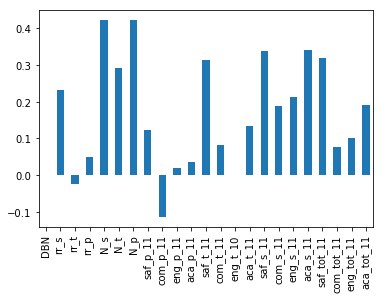

In [13]:
correlations[survey_fields].plot.bar()

## Findings
* There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.
* It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

# Explore the safety at the school
* saf_t_11 - Safety and Respect score based on teacher responses

* saf_s_11 - Safety and Respect score based on student responses

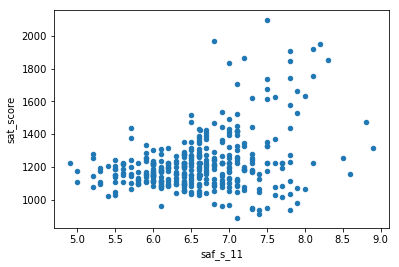

In [14]:
combined.plot.scatter(x = 'saf_s_11', y = 'sat_score')

## Findings
* Tt looks like there is relationship between safety and SAT Score. Not 100 percent linear. high safety scores -> high SAT scores.

* There are some schools with high safety scores and high SAT scores.

* There are some schools with low safety sores and low SAT scores.

* There are not single schools with safety scores lower than 6.5 have SAT Score higher than 1600.


# Plotting the average safety score for each district on the maps

In [15]:
#average safety scores for each district
avg_safety_score_by_district = combined.groupby('saf_s_11').agg(np.mean)
avg_safety_score_by_district.reset_index(inplace = True)
avg_safety_score_by_district.head()

,saf_s_11,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,4.9,404.119403,419.656716,399.662687,1223.438806,129.028846,197.038462,153.4500,193.870968,16.00,...,12.0,12.0,11221.00,148.00,1.00,0.0,0.0,0.0,40.691538,-73.933726
1,5.0,384.000000,384.000000,372.000000,1140.000000,45.000000,64.500000,84.2250,521.500000,26.50,...,12.0,12.0,11430.50,1474.50,4.50,0.0,0.0,0.0,40.704172,-73.761541
2,5.2,397.250000,402.750000,388.000000,1188.000000,178.257212,266.259615,161.2250,414.750000,14.25,...,12.0,12.0,10315.75,1332.75,3.75,0.0,0.0,0.0,40.804269,-73.959020
3,5.3,383.500000,389.000000,368.750000,1141.250000,79.507212,113.509615,119.5875,184.500000,20.25,...,12.0,12.0,11262.25,614.75,3.25,0.0,0.0,0.0,40.693704,-73.869222
4,5.4,377.000000,372.500000,364.000000,1113.500000,76.514423,112.019231,153.4500,116.500000,16.50,...,12.0,12.0,11209.00,468.50,1.50,0.0,0.0,0.0,40.689758,-73.917617


/Users/jianwenwu/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/jianwenwu/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


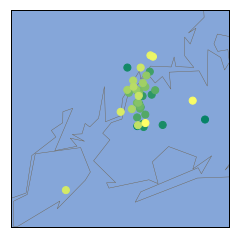

In [30]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
longitudes = avg_safety_score_by_district["lon"].tolist()
latitudes = avg_safety_score_by_district["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=avg_safety_score_by_district["saf_s_11"], cmap="summer")
#plt.show()

## Findings

* Upper Manhattan, Bronx, and part of Queens tend to have lower safety scores.

* Brooklyn has highest safety scores

# Explore Racial differences in SAT performance

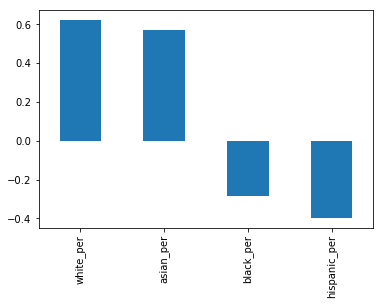

In [17]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()




## Findings 
* It looks like higher percentage of white or asian correlates positively with sat score. In contrast, higher percentage of black or hispanic correlates negatively with sat score.

* Those schools with high percentage of black or hispanics may have very limited fundings.  This may cause them to have low SAT score.

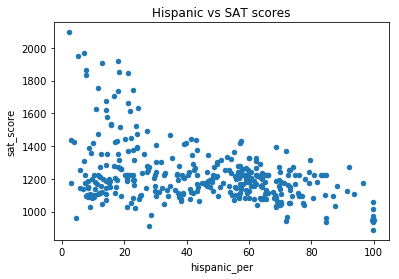

In [18]:
combined.plot.scatter("hispanic_per", "sat_score", title = 'Hispanic vs SAT scores')

## Findings
* It looks like there is negative correlaton between percentage of hispanic per school with SAT scores.

#### Research any schools with a hispanic_per greater than 95%

In [19]:
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

* Those schools have many English Language Learners.  This is main reason indicated those school have low SAT scores.

#### Research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800


In [20]:
combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

* Those Schools are specialized science and technology schools. They usually received extra fundings have more resouces.  They do not have many English Language Learners.

* This indicated that students in those students tend to do well on SAT, because they are students who did well on a standardized test.(Those schools need high standarized test to get in)

# Explore the Gender differences in SAT scores

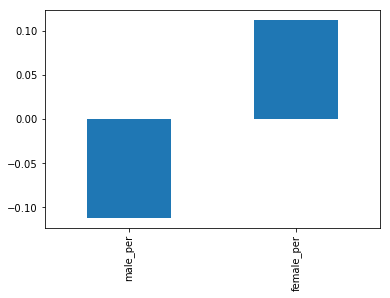

In [21]:
gender = ['male_per', 'female_per']
combined.corr()['sat_score'][gender].plot.bar()

* Higher percentage of female positively correlates with SAT score.
* Higher percentage of male negatively correlates with SAT score.
* But Neither correlation is extremely strong.

#### schools with high SAT scores and a high female_per

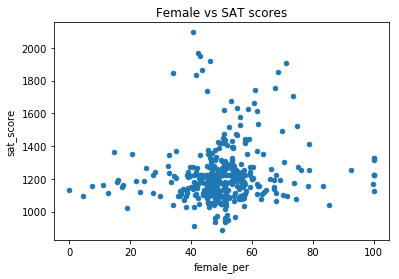

In [22]:
combined.plot.scatter('female_per', 'sat_score', title = 'Female vs SAT scores')

* There is no real correlation between sat_score and female_per.
* There is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

#### Research any schools with a female_per greater than 60% and an average SAT score greater than 1700.

In [23]:
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

* These schools appears to be very selective liberal arts schools that have high academic standards

# Explore AP exam vs SAT scores

In [24]:
# percentage of students in each school that took an AP exam
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

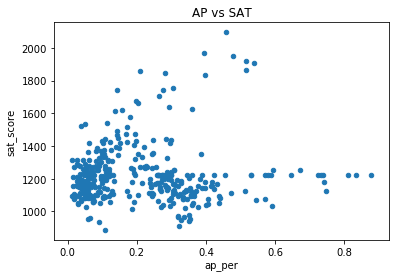

In [25]:
combined.plot.scatter('ap_per', 'sat_score', title = "AP vs SAT")

* There is relationship between percentage of students in a school who take the AP exam, and their average SAT scores.  However, it is not a strong relationship.

# Explore class size vs SAT scores

In [26]:
combined.corr()['sat_score']['AVERAGE CLASS SIZE']

0.38101433080955233

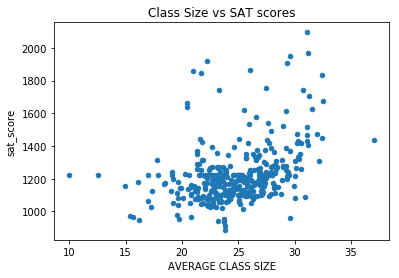

In [27]:
combined.plot.scatter('AVERAGE CLASS SIZE', 'sat_score', title = 'Class Size vs SAT scores')

*  There is correlation between class size, and SAT scores. However, it is not a stronge correlation.

* It looks like bigger class size tends to have higher SAT scores.  We usually think that smaller class size tends to help student more, because they will have more attention from teachers.

# Investigating the differences between parent, teacher, and student responses to surveys

##### Parent Responses
* saf_p_11	Safety and Respect score based on parent responses
* com_p_11	Communication score based on parent responses
* eng_p_11	Engagement score based on parent responses
* aca_p_11	Academic expectations score based on parent responses

##### Teacher Responses
* saf_t_11	Safety and Respect score based on teacher responses
* com_t_11	Communication score based on teacher responses
* eng_t_11	Engagement score based on teacher responses
* aca_t_11	Academic expectations score based on teacher responses

##### Student Responses
* saf_s_11	Safety and Respect score based on student responses
* com_s_11	Communication score based on student responses
* eng_s_11	Engagement score based on student responses
* aca_s_11	Academic expectations score based on student responses

In [57]:
safety_scores = ['saf_p_11', 'saf_t_11', 'saf_s_11']
communication_scores = ['com_p_11','com_t_11','com_s_11']
engagement_scores = ['eng_p_11', 'eng_t_10' ,'eng_s_11']
academic_expectations_scores = ['aca_p_11', 'aca_t_11', 'aca_s_11']
                                

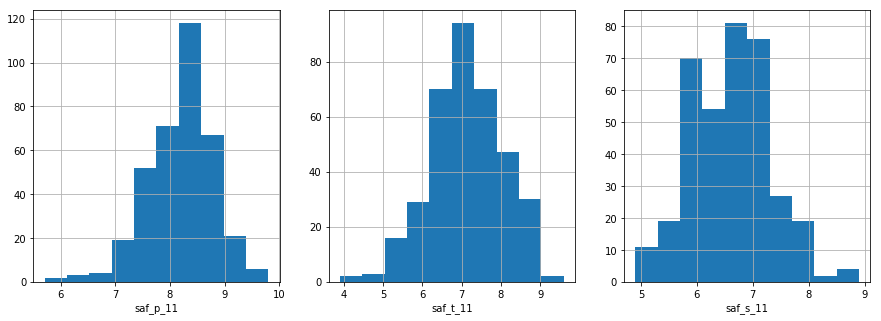

In [65]:
fig = plt.figure(figsize=(15,5))
for r in range(0,3):
    ax = fig.add_subplot(1,3,r+1)
    ax = combined[safety_scores[r]].hist()
    ax.set_xlabel(safety_scores[r])

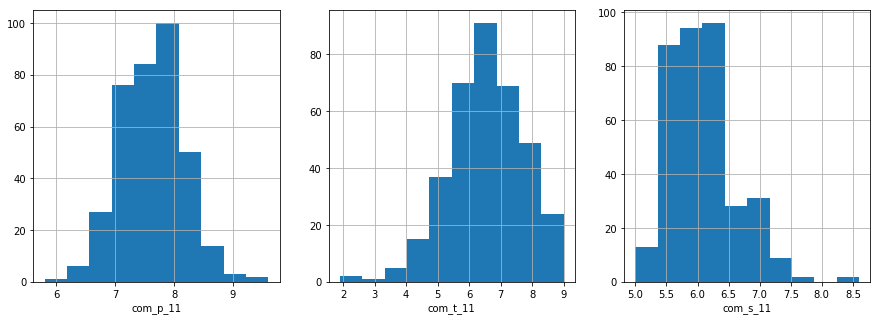

In [66]:
fig = plt.figure(figsize=(15,5))
for r in range(0,3):
    ax = fig.add_subplot(1,3,r+1)
    ax = combined[communication_scores[r]].hist()
    ax.set_xlabel(communication_scores[r])

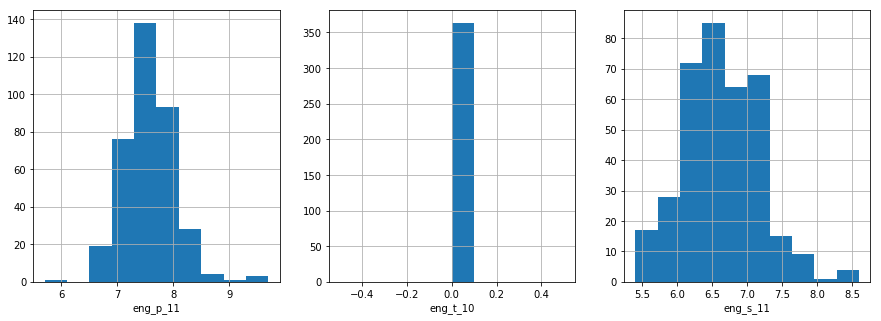

In [67]:
fig = plt.figure(figsize=(15,5))
for r in range(0,3):
    ax = fig.add_subplot(1,3,r+1)
    ax = combined[engagement_scores[r]].hist()
    ax.set_xlabel(engagement_scores[r])

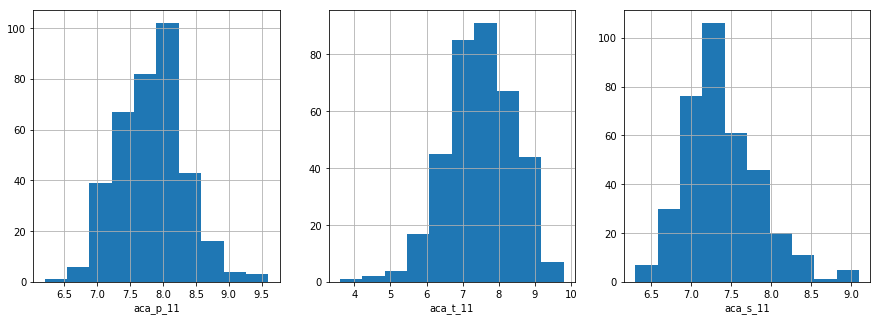

In [68]:
fig = plt.figure(figsize=(15,5))
for r in range(0,3):
    ax = fig.add_subplot(1,3,r+1)
    ax = combined[academic_expectations_scores[r]].hist()
    ax.set_xlabel(academic_expectations_scores[r])